# Advanced Lane Finding Project

### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Apply a Mask to extract only the lane part of the perspective transformed image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Note: Added one more point to the above goals for masking the perspective transformed image to extract only the 
lane part of the image.

In [241]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from itertools import groupby, islice, zip_longest, cycle, filterfalse

### Helper Methods

below are some helper methods used to build the pipeline to transform the image before finding the lane lines

In [242]:
# method to visualize the given images in 2*3 grid format

def visualize(filename, a):
    fig, axes = plt.subplots(2,3,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
    fig.subplots_adjust(hspace=0.03, wspace=0.05)
    for p in zip(sum(axes.tolist(),[]), a):
        p[0].imshow(p[1],cmap='gray')
    plt.tight_layout()
    fig.savefig(filename)
    #plt.close()

In [243]:
# method to mask out all the image except the region specified by the vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [244]:
# method to calibrate the distortion coefficients of the camera from the images in the camera_cal folder.

def getDistortionCoefficients():

    images = glob.glob('./camera_cal/calibration*.jpg')

    objPoints = []
    imgPoints = []

    objP = np.zeros(((6*9),3), np.float32)
    objP[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            objPoints.append(objP)
            imgPoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

In [245]:
# calculating the distortion coefficients of the camera
ret, mtx, dist, rvecs, tvecs = getDistortionCoefficients()

def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

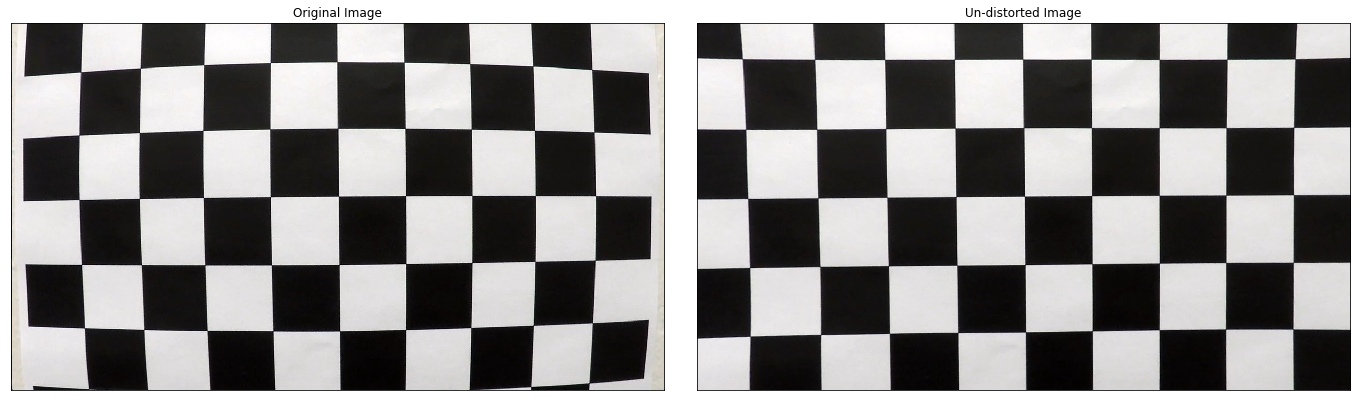

In [290]:
# Test method undistort on an example image

image = mpimg.imread('./camera_cal/calibration1.jpg')

fig, axs = plt.subplots(1,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0].set_title('Original Image')
axs[0].imshow(image)

axs[1].set_title('Un-distorted Image')
axs[1].imshow(undistort(image))

fig.savefig("./output_images/Undistortion.jpg")

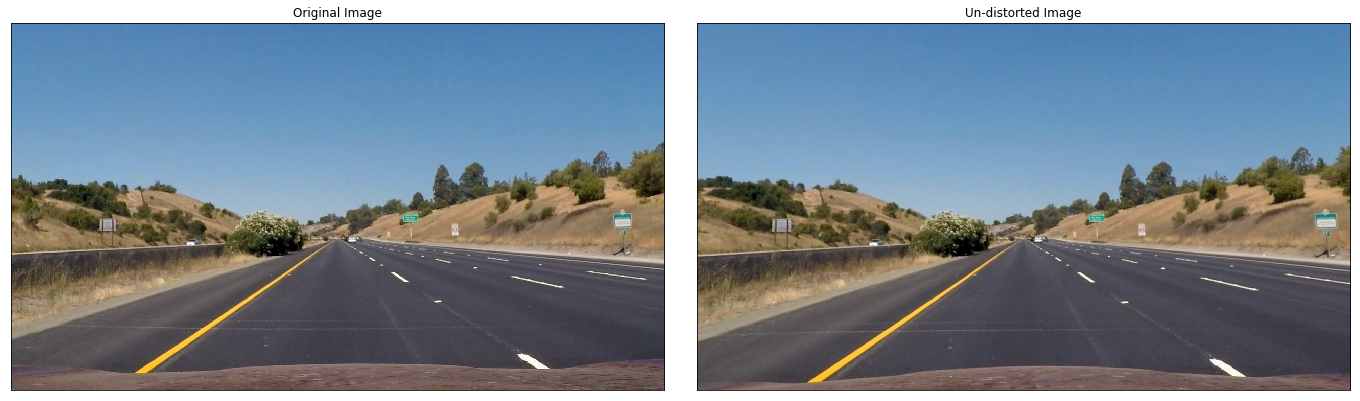

In [291]:
# Test method undistort on an example image

image = mpimg.imread('./test_images/straight_lines1.jpg')

fig, axs = plt.subplots(1,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0].set_title('Original Image')
axs[0].imshow(image)

axs[1].set_title('Un-distorted Image')
axs[1].imshow(undistort(image))

fig.savefig("./output_images/Undistortion_Road.jpg")

In [247]:
# method to the transform the road-image to a top-view so that the lanes are parallel

def pers_Trans(img):

    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_size = (gray.shape[1], gray.shape[0])
    
    src = np.float32([[215,720],[600,450],[690,450],[1115,720]])

    dst = np.float32([[400,720],[400,0],[890,0],[890,720]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

    # Return the resulting image and matrix
    return warped, M, Minv

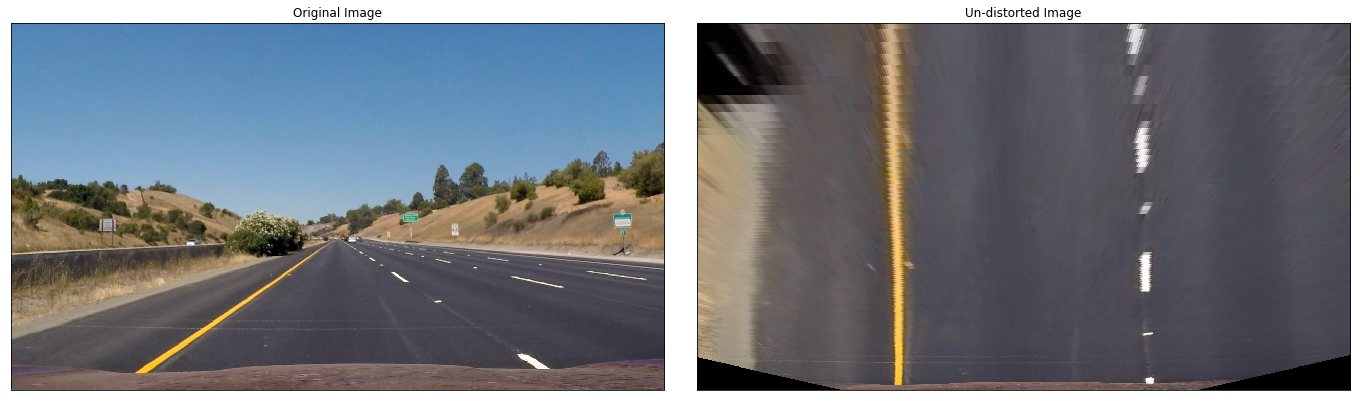

In [248]:
# Test method pers_Trans on an example image

image = mpimg.imread('./test_images/straight_lines1.jpg')

fig, axs = plt.subplots(1,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0].set_title('Original Image')
axs[0].imshow(image)

axs[1].set_title('Un-distorted Image')
axs[1].imshow(pers_Trans(image)[0])

fig.savefig("./output_images/Perspective.jpg")

In [249]:
# method to convert image to binary image by thresholding the magnitude of gradients in a specific direction

def mag_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    if orient == 'both': 
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [250]:
# method to convert image to binary image by thresholding the direction of gradients

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [251]:
# method combining magnitude(both) and direction thresholding
def mag_dir_threshold(img, nx, ny, mtx, dist):
    
    #gradient thresholding
    mag_binary = abs_sobel_thresh(dst, orient='both',sobel_kernel=31, thresh_min=20, thresh_max=100)
    
    dir_binary = dir_threshold(dst, sobel_kernel=31, thresh=(1, 1.5))
    
    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return dir_binary

### Magnitude Threshold

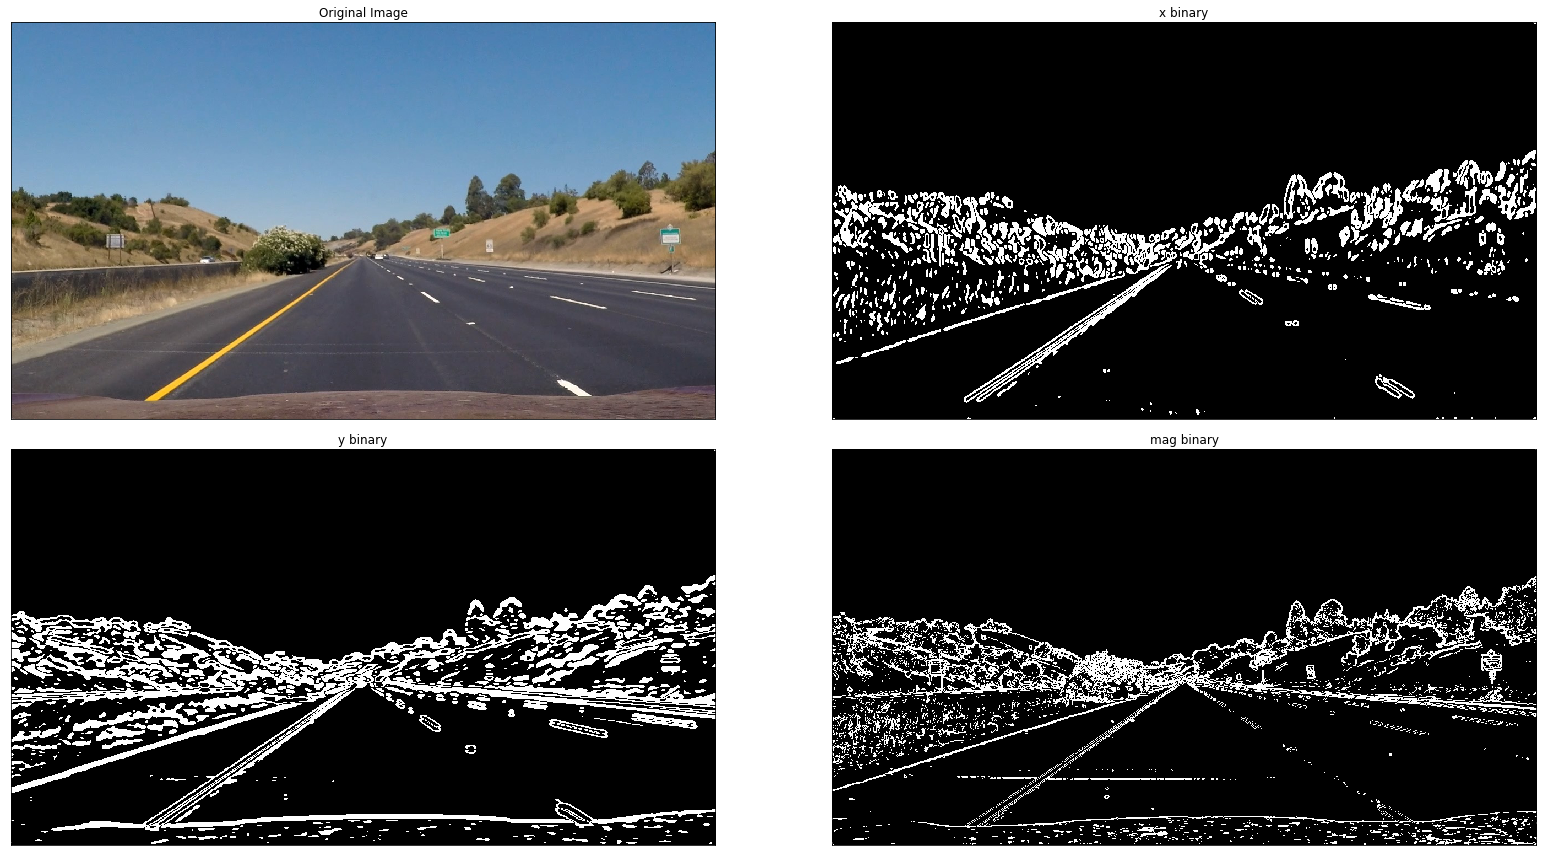

In [252]:
# Visualizing Magnitude Thresholding

image = mpimg.imread('./test_images/straight_lines1.jpg')
x_binary = mag_thresh(image, orient='x', sobel_kernel=31, thresh_min=20, thresh_max=100)
y_binary = mag_thresh(image, orient='y', sobel_kernel=31, thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, orient='both', sobel_kernel=3, thresh_min=20, thresh_max=100)

fig, axs = plt.subplots(2,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0,0].set_title('Original Image')
axs[0,0].imshow(image,cmap='gray')

axs[0,1].set_title('x binary')
axs[0,1].imshow(x_binary, cmap='gray')

axs[1,0].set_title('y binary')
axs[1,0].imshow(y_binary, cmap='gray')

axs[1,1].set_title('mag binary')
axs[1,1].imshow(mag_binary, cmap='gray')
plt.tight_layout()

fig.savefig("./output_images/Magnitude_Threshold.jpg")

### Direction Threshold

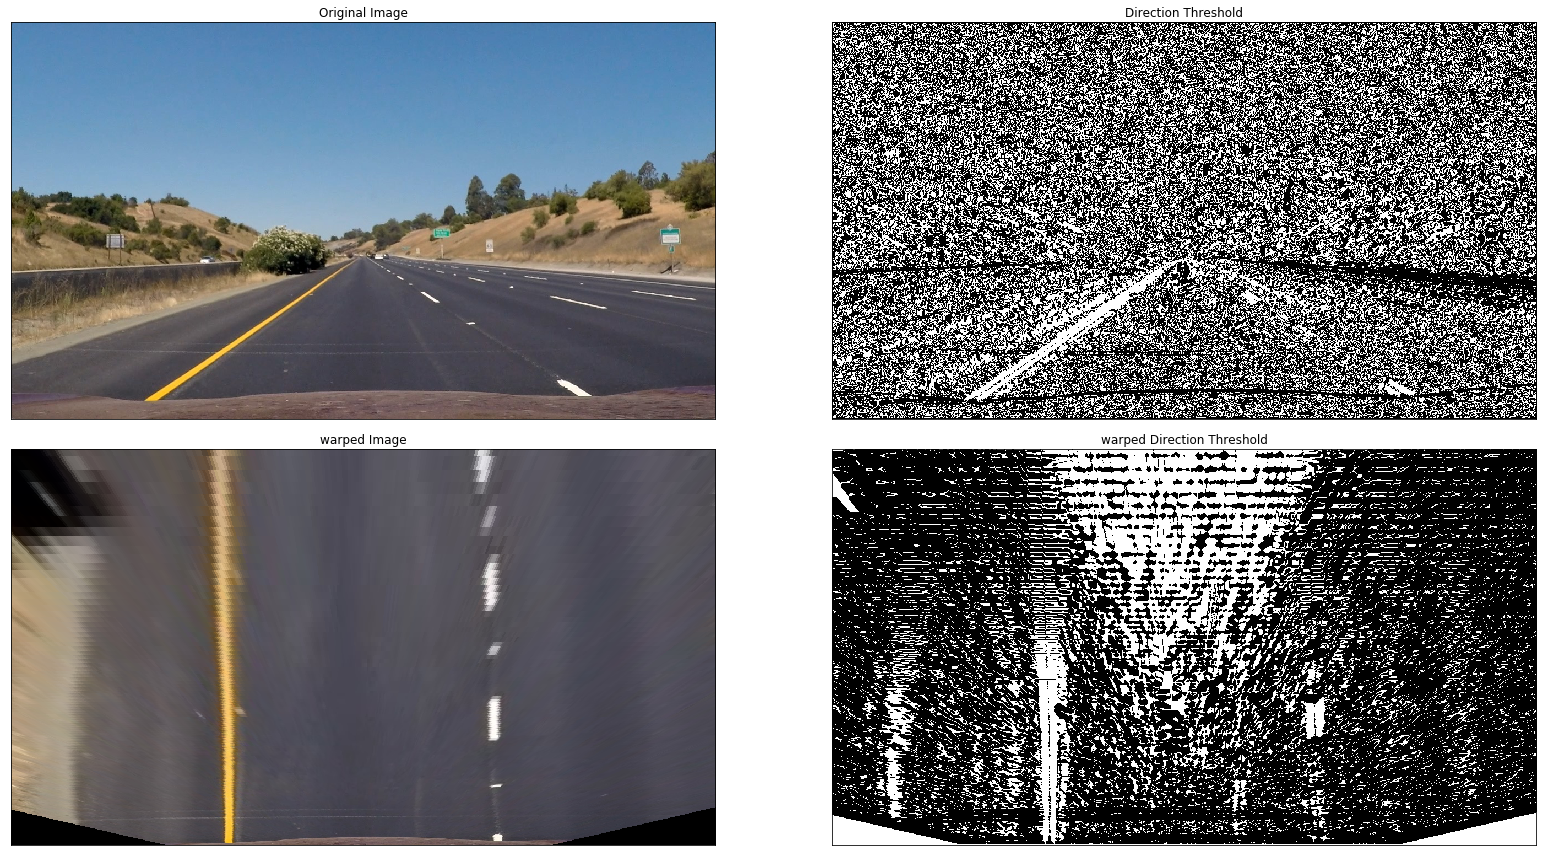

In [253]:
# Visualizing Direction Thresholding

image = mpimg.imread('./test_images/straight_lines1.jpg')
dir_binary = dir_threshold(image, sobel_kernel=11, thresh=(0.7, 1.3))

warp_img, M = pers_Trans(undistort(image))[:2]
warp_dir_binary = dir_threshold(warp_img, sobel_kernel=17, thresh=(0, 0.3))

fig, axs = plt.subplots(2,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0,0].set_title('Original Image')
axs[0,0].imshow(image,cmap='gray')

axs[0,1].set_title('Direction Threshold')
axs[0,1].imshow(dir_binary, cmap='gray')

axs[1,0].set_title('warped Image')
axs[1,0].imshow(warp_img, cmap='gray')

axs[1,1].set_title('warped Direction Threshold')
axs[1,1].imshow(warp_dir_binary, cmap='gray')

plt.tight_layout()

fig.savefig("./output_images/Direction_Threshold.jpg")

### Combined Magnitude and Direction Thresholding

In [254]:
# method combining magnitude(x) and direction thresholding
def mag_dir_threshold(image):
    
    x_binary = mag_thresh(image, orient='x', sobel_kernel=31, thresh_min=20, thresh_max=100)
    dir_binary = dir_threshold(image, sobel_kernel=11, thresh=(0, 0.8))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(x_binary)
    combined_binary[(x_binary == 1) & (dir_binary == 1)] = 1
    
    return combined_binary

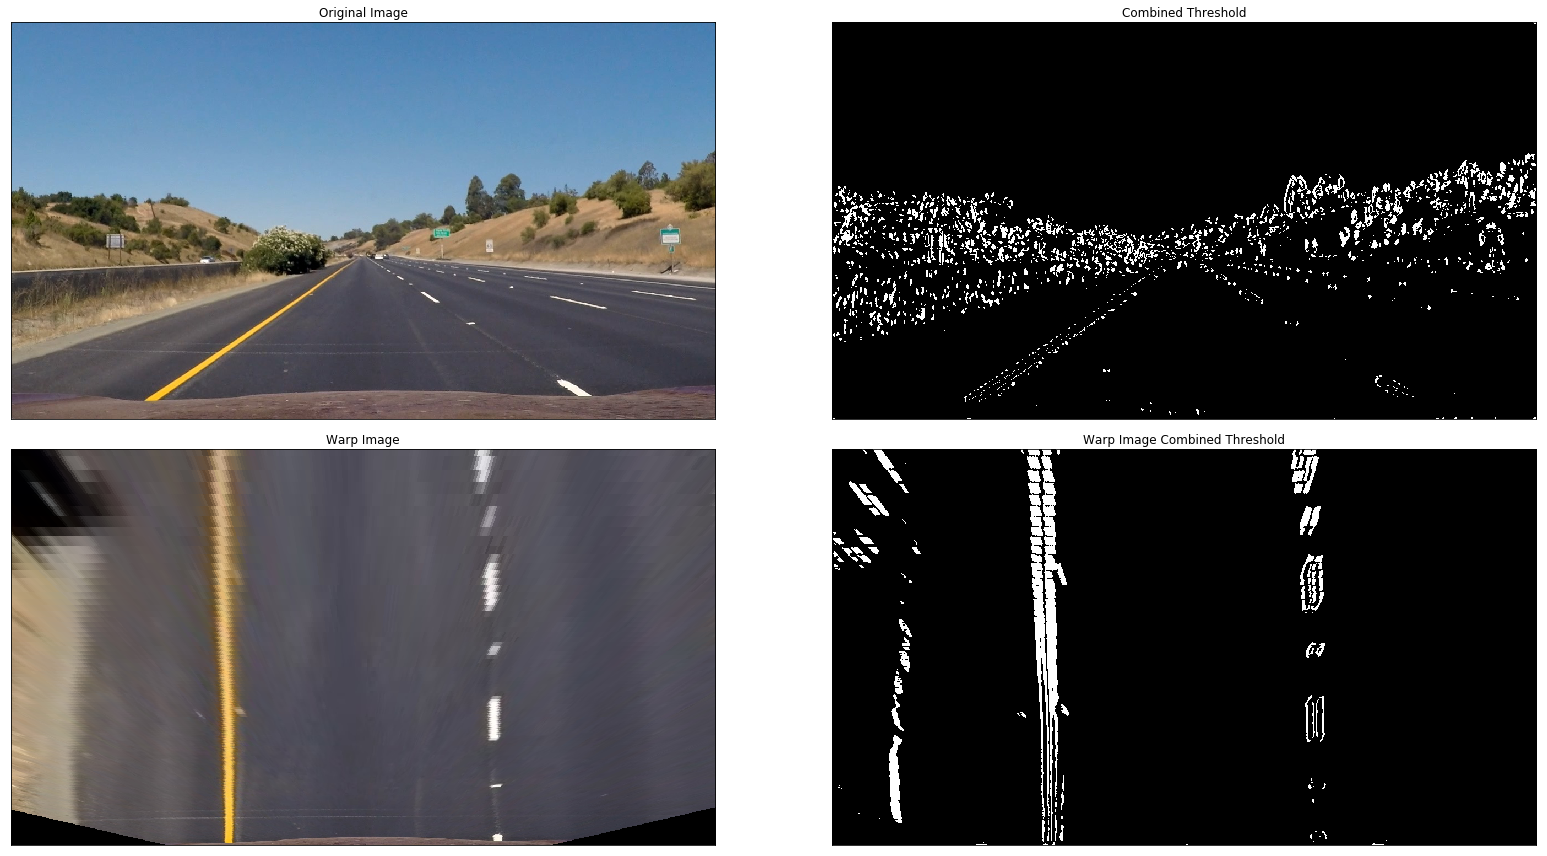

In [255]:
# Visualizing Combined Magnitude and Direction Thresholding

image = mpimg.imread('./test_images/straight_lines1.jpg')

# Magnitude threshold original image
combined_binary = mag_dir_threshold(image)

# Perspective transformed image
warp_img, M = pers_Trans(undistort(image))[:2]

# Magnitude threshold Perspective transformed image
warp_combined_binary = mag_dir_threshold(warp_img)

fig, axs = plt.subplots(2,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0,0].set_title('Original Image')
axs[0,0].imshow(image,cmap='gray')

axs[0,1].set_title('Combined Threshold')
axs[0,1].imshow(combined_binary, cmap='gray')

axs[1,0].set_title('Warp Image')
axs[1,0].imshow(warp_img, cmap='gray')

axs[1,1].set_title('Warp Image Combined Threshold')
axs[1,1].imshow(warp_combined_binary, cmap='gray')
plt.tight_layout()

fig.savefig("./output_images/Combined_Thresholding.jpg")

### Masking

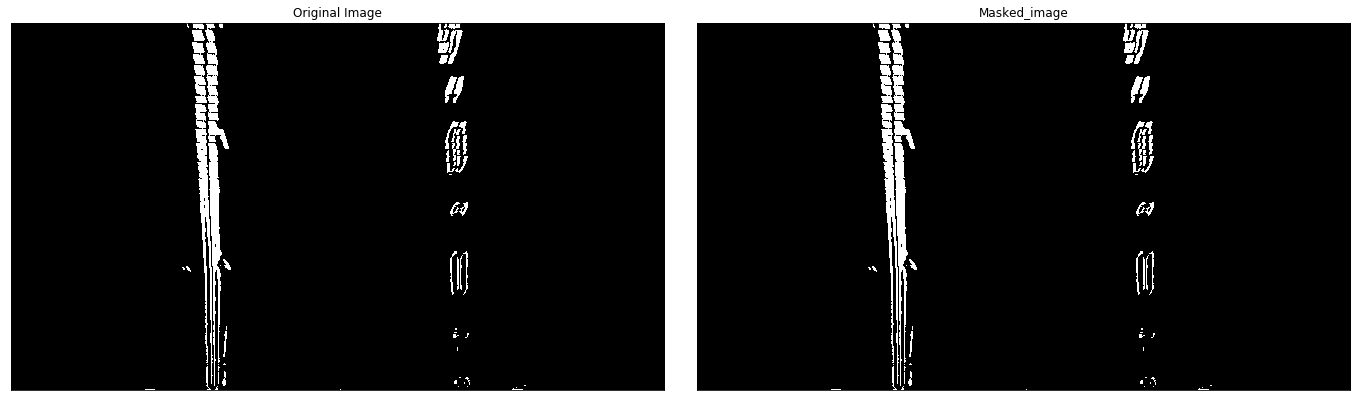

In [256]:
image = mpimg.imread('./test_images/straight_lines1.jpg')

warped = pipeline(image)

imshape = warped.shape
vertices = np.array([[(250,imshape[0]),(1100, imshape[0]), (1100, 0), (250,0)]], dtype=np.int32)

masked_image = region_of_interest(warped, vertices)

fig, axs = plt.subplots(1,2,figsize=(24,12),subplot_kw={'xticks':[],'yticks':[]})
fig.subplots_adjust(hspace=0.03, wspace=0.05)

axs[0].set_title('Original Image')
axs[0].imshow(warped, cmap = 'gray')

axs[1].set_title('Masked_image')
axs[1].imshow(masked_image, cmap = 'gray')

fig.savefig("./output_images/Masking.jpg")

### Pipeline 1

 Making a pipeline with the following steps
 1. Undistortion
 2. Perspective Transform
 3. Conbinened Magnitude and Direction Thresholding
 4. Masking Lane Area

In [257]:

def pipeline(image):
    return region_of_interest(mag_dir_thresh(pers_Trans(undistort(image))[0]), vertices)

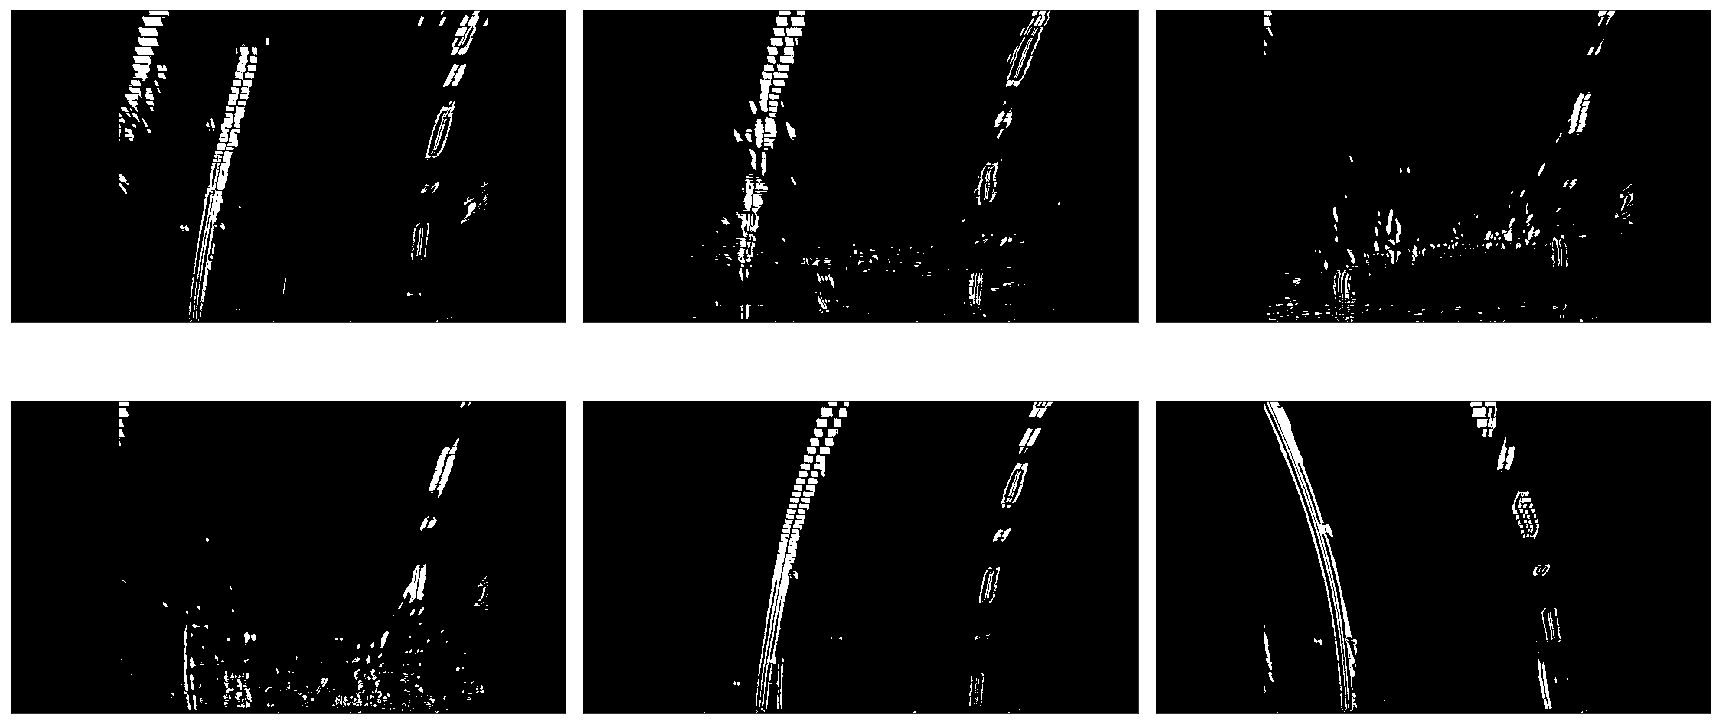

In [258]:
visualize("output_images/pipeline.jpg",
          (pipeline(mpimg.imread(f)) for f in cycle(glob.glob("./test_images/test*.jpg"))))

### Colour Thresholding

In [259]:
def rgb_select(img):
    rgb = img
    r = rgb[:,:,0]
    g = rgb[:,:,1]
    b = rgb[:,:,2]
    return r,g,b

In [260]:
def hls_select(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h = hsv[:,:,0]
    l = hsv[:,:,1]
    s = hsv[:,:,2]
    return h,l,s

In [261]:
def threshold(img, thresh_min=0, thresh_max=255):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh_min) & (img <= thresh_max)] = 1
    return binary_output

In [262]:
def scale(img, factor=1.0):
    scale_factor = np.max(img)/factor
    return (img/scale_factor).astype(np.uint8)

In [263]:
land = lambda *x: np.logical_and.reduce(x)
lor = lambda *x: np.logical_or.reduce(x)

In [264]:
def highlight(img):
    r,g,b = rgb_select(img)
    h,l,s = hls_select(img)
    o01 = threshold(r, 200, 255)
    o02 = threshold(g, 200, 255)
    o03 = threshold(s, 200, 255)
    return scale(lor(land(o01,o02),o03))

### Pipeline 2

 Making a pipeline with the following steps
 1. Undistortion
 2. Perspective Transform
 3. Color Thresholding
 4. Masking Lane Area

In [265]:
def pipeline2(image):
    
    return region_of_interest(highlight(pers_Trans(undistort(image))[0]), vertices)

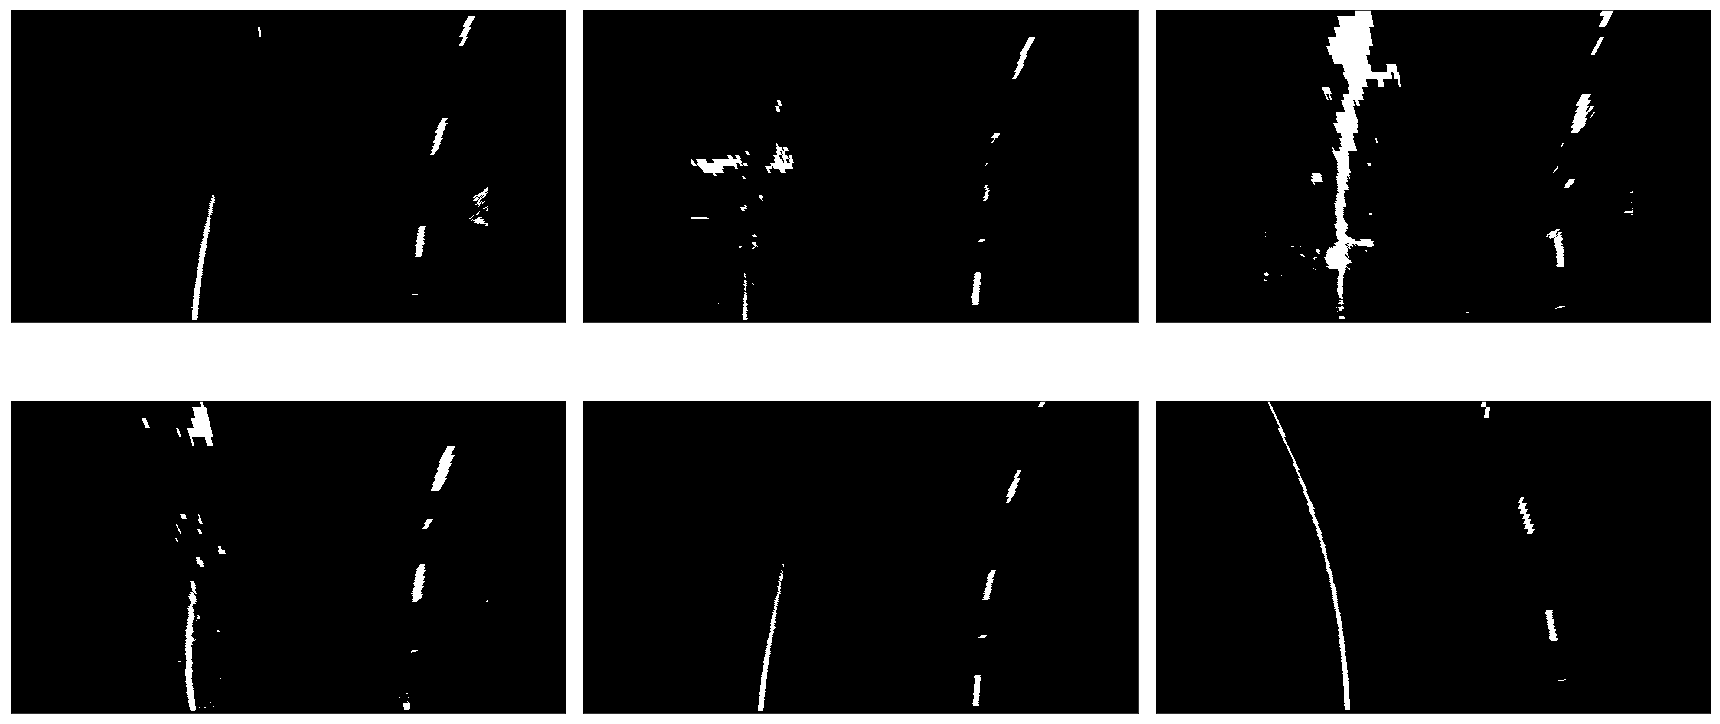

In [266]:
visualize("output_images/Pipeline2.jpg",
          (pipeline2(mpimg.imread(f)) for f in cycle(glob.glob("./test_images/test*.jpg"))))

### Pipeline 3

 Making a pipeline with the following steps
 1. Undistortion
 2. Perspective Transform
 3. Magnitude Thresholding
 4. Color Thresholding
 5. Masking Lane Area

In [267]:
def pipeline3(img):

    mag_thresh = pipeline(img)
    color_thresh = pipeline2(img)
    
    return lor(mag_thresh,color_thresh)/1.0


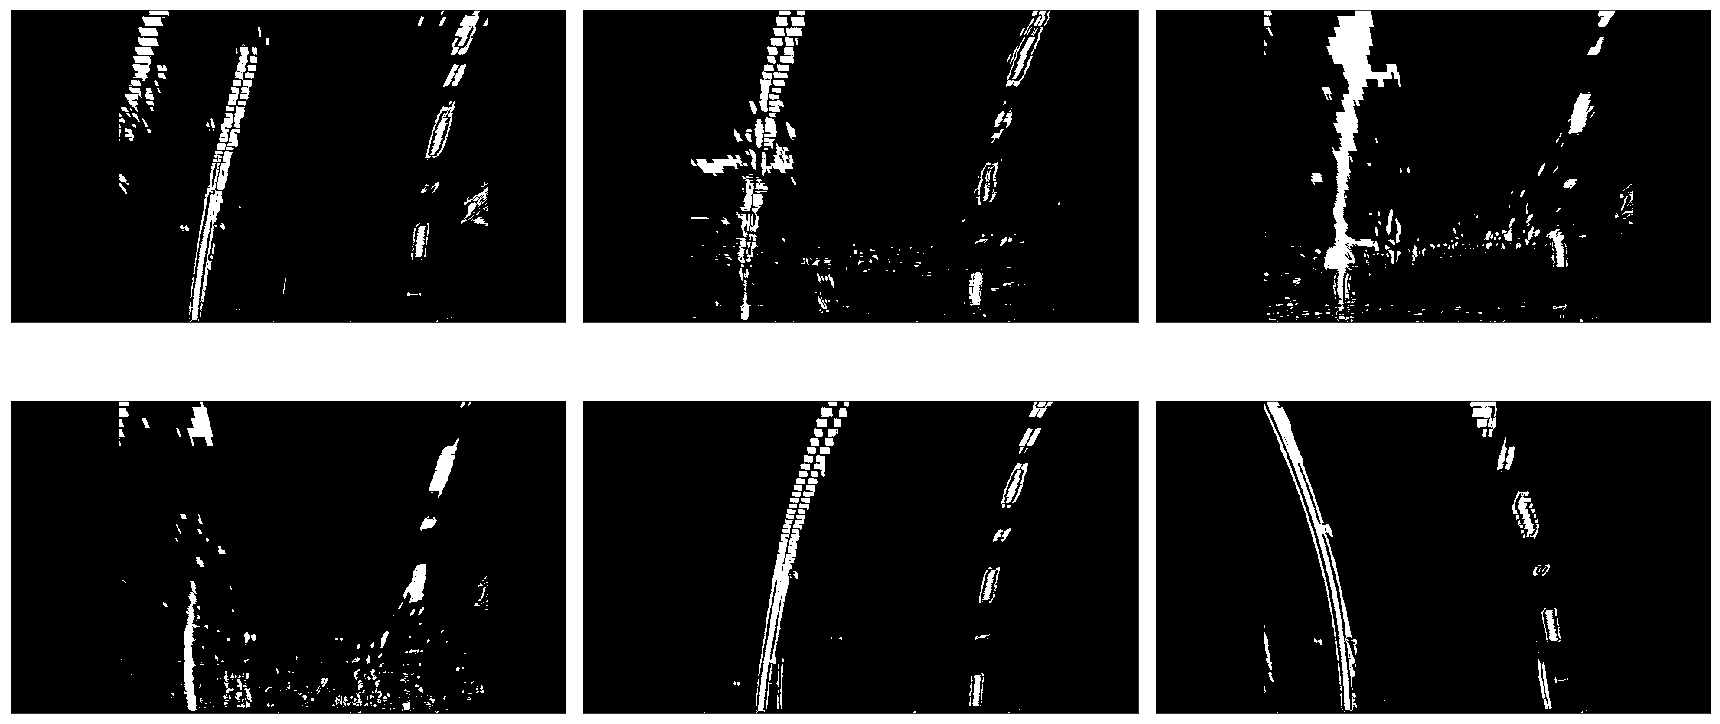

In [268]:
visualize("output_images/Pipeline3.jpg",
          (pipeline4(mpimg.imread(f)) for f in cycle(glob.glob("./test_images/test*.jpg"))))

### Histogram of an image applied to pipeline3

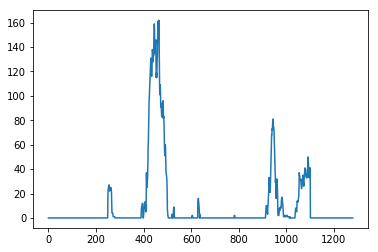

In [269]:
image = mpimg.imread('./test_images/test6.jpg')

img = pipeline3(image)

histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

plt.plot(histogram)

plt.savefig('output_images/Histogram_Detected_Lane_Pixels.jpg')

### Methods to finding lanes lines on warped images and projecting back to the original image

The code in these methods are taken from lecture notes and refactored to remove duplicate code in different methods.

In [270]:
# This method returns the lane line points in the image using sliding window approach

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return out_img, leftx, lefty, rightx, righty

In [271]:
# This method fits a polynomial for the left and right lanes and also finds their radius of curvature

def fit_poly_c(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_real = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
    right_fit_real = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_real[0]*y_eval*ym_per_pix + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0])
    right_curverad = ((1 + (2*right_fit_real[0]*y_eval*ym_per_pix + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0])
    
    return left_fit, right_fit, left_curverad, right_curverad

In [272]:
# This method houses the methods to detect lane line points and fits polynomials using sliding window approach

def detect_Lanes_Histogram_c(binary_warped):
    # Find our lane pixels first
    _, leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit new polynomials
    left_fit, right_fit, left_curverad, right_curverad = fit_poly_c(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, left_curverad, right_curverad

In [273]:
# This method houses the methods to detect lane line points and fits polynomials by searching around the
# lines detected in the previous frame

def detect_Lanes_Search_Around_c(binary_warped, left_fit, right_fit):
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_curverad, right_curverad = fit_poly_c(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, left_curverad, right_curverad

In [274]:
# This method warps back the detected lane polynomials onto the original image

def draw_lane(binary_warped, image, left_fit, right_fit, left_curverad, right_curverad):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Annotate image with lane curvature estimates
    cv2.putText(result, "L. Curvature: %.2f km" % (left_curverad/1000), (50,50), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    cv2.putText(result, "R. Curvature: %.2f km" % (right_curverad/1000), (50,80), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    # Annotate image with position estimate
    cv2.putText(result, "C. Position: %.2f m" % ((np.average((left_fitx + left_fitx)/2) - binary_warped.shape[1]//2)*3.7/700), (50,110), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 2)
    
    return result    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


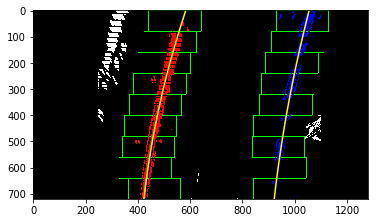

In [275]:
# Visualizing the detected lane points(seen in red and blue dots) using sliding window method
# also fitted lines are shown in yellow lines

image = mpimg.imread('./test_images/test6.jpg')

warped_binary = pipeline3(image)

out_img, leftx, lefty, rightx, righty = find_lane_pixels(warped_binary)

# Fit a second order polynomial to each using `np.polyfit`
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
    
plt.imshow(out_img)
plt.savefig('output_images/Sliding_Window.jpg')

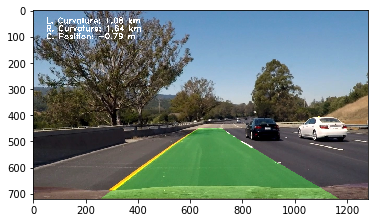

In [276]:
# Visualizing the detected lane warped back onto the original image

left_fit, right_fit, left_curverad, right_curverad = detect_Lanes_Histogram_c(warped_binary)
annotated_image = draw_lane(warped_binary, image, left_fit, right_fit, left_curverad, right_curverad)

plt.imshow(annotated_image)

plt.savefig('output_images/Final_Output.jpg')

### Processor for Images

This method is taken from https://dventimi.github.io/CarND-Advanced-Lane-Lines/writeup.html

"One other thing that this function does is this. It takes a weighted average of some number of recent frames, along with the current frame. This removes "jitter" from the lanes and values on the video streams, and adds robustness against bad detections on individual frames. It uses dequeue to create "ring buffers" for the left lane parameters, right lane parameters, left lane radius, and right lane radius. The buffers can be of any size, though the default has 10 slots. Note that a buffer size of 1 essentially computes no average at all. Weighted averages are taken across these buffers. The weights could be taken from any function, simple or complex, that is appropriate for the situation. In practice I did not try for anything complicated, and used a simple linear weighting scheme: older frames have strictly linearly less weight."

In [292]:
# Method used Moviepy to process frames 

from collections import deque

def get_processor(nbins=10):
    bins = nbins
    l_params = deque(maxlen=bins)
    r_params = deque(maxlen=bins)
    l_radius = deque(maxlen=bins)
    r_radius = deque(maxlen=bins)
    weights = np.arange(1,bins+1)/bins
    def process_image(image):
        warped_binary = pipeline3(image)
        left_fit, right_fit, left_curverad, right_curverad = detect_Lanes_Histogram_c(warped_binary) if len(l_params)==0 else detect_Lanes_Search_Around_c(warped_binary,np.average(l_params,0,weights[-len(l_params):]), np.average(r_params,0,weights[-len(l_params):]))
        l_params.append(left_fit)
        r_params.append(right_fit)
        l_radius.append(left_curverad)
        r_radius.append(right_curverad)
        annotated_image = draw_lane(warped_binary, image,
                                    np.average(l_params,0,weights[-len(l_params):]),
                                    np.average(r_params,0,weights[-len(l_params):]),
                                    np.average(l_radius,0,weights[-len(l_params):]),
                                    np.average(r_radius,0,weights[-len(l_params):]))
        return annotated_image
    return process_image

In [293]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [294]:

output = 'output_videos/pipeline3_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(get_processor(50)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/pipeline3_challenge_video.mp4
[MoviePy] Writing video output_videos/pipeline3_challenge_video.mp4





  0%|          | 0/485 [00:00<?, ?it/s]


  0%|          | 1/485 [00:00<02:00,  4.01it/s]


  0%|          | 2/485 [00:00<02:07,  3.80it/s]


  1%|          | 3/485 [00:00<02:08,  3.76it/s]


  1%|          | 4/485 [00:01<02:06,  3.81it/s]


  1%|          | 5/485 [00:01<02:04,  3.87it/s]


  1%|          | 6/485 [00:01<02:01,  3.93it/s]


  1%|▏         | 7/485 [00:01<02:00,  3.96it/s]


  2%|▏         | 8/485 [00:02<01:59,  3.99it/s]


  2%|▏         | 9/485 [00:02<01:59,  3.97it/s]


  2%|▏         | 10/485 [00:02<01:59,  3.97it/s]


  2%|▏         | 11/485 [00:02<01:59,  3.97it/s]


  2%|▏         | 12/485 [00:03<01:58,  3.99it/s]


  3%|▎         | 13/485 [00:03<01:57,  4.00it/s]


  3%|▎         | 14/485 [00:03<01:56,  4.03it/s]


  3%|▎         | 15/485 [00:03<01:56,  4.04it/s]


  3%|▎         | 16/485 [00:03<01:56,  4.04it/s]


  4%|▎         | 17/485 [00:04<01:55,  4.05it/s]


  4%|▎         | 18/485 [00:04<01:55,  4.06it/s]


  4%|▍         | 19/485 [00:04<01:54,  4.06it/

 28%|██▊       | 136/485 [00:31<01:22,  4.25it/s]


 28%|██▊       | 137/485 [00:32<01:21,  4.25it/s]


 28%|██▊       | 138/485 [00:32<01:21,  4.26it/s]


 29%|██▊       | 139/485 [00:32<01:21,  4.25it/s]


 29%|██▉       | 140/485 [00:32<01:21,  4.25it/s]


 29%|██▉       | 141/485 [00:33<01:20,  4.25it/s]


 29%|██▉       | 142/485 [00:33<01:20,  4.25it/s]


 29%|██▉       | 143/485 [00:33<01:20,  4.25it/s]


 30%|██▉       | 144/485 [00:33<01:20,  4.25it/s]


 30%|██▉       | 145/485 [00:34<01:20,  4.25it/s]


 30%|███       | 146/485 [00:34<01:19,  4.25it/s]


 30%|███       | 147/485 [00:34<01:19,  4.25it/s]


 31%|███       | 148/485 [00:34<01:19,  4.25it/s]


 31%|███       | 149/485 [00:35<01:19,  4.24it/s]


 31%|███       | 150/485 [00:35<01:19,  4.24it/s]


 31%|███       | 151/485 [00:35<01:18,  4.24it/s]


 31%|███▏      | 152/485 [00:35<01:18,  4.23it/s]


 32%|███▏      | 153/485 [00:36<01:18,  4.22it/s]


 32%|███▏      | 154/485 [00:36<01:18,  4.21it/s]


 32%|███▏   

 56%|█████▌    | 270/485 [01:03<00:50,  4.25it/s]


 56%|█████▌    | 271/485 [01:03<00:50,  4.25it/s]


 56%|█████▌    | 272/485 [01:04<00:50,  4.25it/s]


 56%|█████▋    | 273/485 [01:04<00:49,  4.25it/s]


 56%|█████▋    | 274/485 [01:04<00:49,  4.25it/s]


 57%|█████▋    | 275/485 [01:04<00:49,  4.25it/s]


 57%|█████▋    | 276/485 [01:04<00:49,  4.25it/s]


 57%|█████▋    | 277/485 [01:05<00:48,  4.25it/s]


 57%|█████▋    | 278/485 [01:05<00:48,  4.26it/s]


 58%|█████▊    | 279/485 [01:05<00:48,  4.26it/s]


 58%|█████▊    | 280/485 [01:05<00:48,  4.26it/s]


 58%|█████▊    | 281/485 [01:06<00:47,  4.26it/s]


 58%|█████▊    | 282/485 [01:06<00:47,  4.26it/s]


 58%|█████▊    | 283/485 [01:06<00:47,  4.26it/s]


 59%|█████▊    | 284/485 [01:06<00:47,  4.26it/s]


 59%|█████▉    | 285/485 [01:06<00:46,  4.26it/s]


 59%|█████▉    | 286/485 [01:07<00:46,  4.26it/s]


 59%|█████▉    | 287/485 [01:07<00:46,  4.26it/s]


 59%|█████▉    | 288/485 [01:07<00:46,  4.26it/s]


 60%|█████▉ 

 83%|████████▎ | 404/485 [01:33<00:18,  4.31it/s]


 84%|████████▎ | 405/485 [01:33<00:18,  4.31it/s]


 84%|████████▎ | 406/485 [01:34<00:18,  4.31it/s]


 84%|████████▍ | 407/485 [01:34<00:18,  4.31it/s]


 84%|████████▍ | 408/485 [01:34<00:17,  4.31it/s]


 84%|████████▍ | 409/485 [01:34<00:17,  4.31it/s]


 85%|████████▍ | 410/485 [01:35<00:17,  4.31it/s]


 85%|████████▍ | 411/485 [01:35<00:17,  4.31it/s]


 85%|████████▍ | 412/485 [01:35<00:16,  4.31it/s]


 85%|████████▌ | 413/485 [01:35<00:16,  4.31it/s]


 85%|████████▌ | 414/485 [01:35<00:16,  4.31it/s]


 86%|████████▌ | 415/485 [01:36<00:16,  4.31it/s]


 86%|████████▌ | 416/485 [01:36<00:15,  4.31it/s]


 86%|████████▌ | 417/485 [01:36<00:15,  4.31it/s]


 86%|████████▌ | 418/485 [01:36<00:15,  4.31it/s]


 86%|████████▋ | 419/485 [01:37<00:15,  4.31it/s]


 87%|████████▋ | 420/485 [01:37<00:15,  4.32it/s]


 87%|████████▋ | 421/485 [01:37<00:14,  4.32it/s]


 87%|████████▋ | 422/485 [01:37<00:14,  4.32it/s]


 87%|███████

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/pipeline3_challenge_video.mp4 

CPU times: user 2min 8s, sys: 19.6 s, total: 2min 28s
Wall time: 1min 51s
